In [1]:
# For user-defined post processing and plotting functions
import sys
sys.path.insert(0, "../../..")
from utils.plot_utils_v2 import *

Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to fit complex models with ease. 

## Case Study 2: Logistic Growth

We are going to establish a logistic model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! Pandas is the defacto python package for reading in data. It's also smart to handle any necessary data conversions during this step. Our data spans many magnitudes, so we will go ahead and perform our log conversion now. You may not need to and that's just fine! You may not need to and that's just fine! It all depends on what you are looking for.

Note: The "+ 1e-9" is merely a fail-safe against divide-by-zero errors when doing a log transform. Adding a value infitesimally near 0 makes no impact on the data itself and prevents the aformentioned error. Good quick trick to know!

In [2]:
## Cell 1 ##

import pandas as pd

# import alive
dataset = pd.read_csv("../../../case_study_2/python/data/total_cells.csv")
cells = dataset.tail(15)
cells_time = cells['Time (days)'].values
cells_density = 1e6*cells[' Density (1e6/ml)'].values
log_cells_density = np.log(cells_density + 1e-9)

First things first, the ODE system. We will setup the logistic ODE that will adapt to the data. To do this, you will use variables that PyMC gives you by 'default'. Let me explain. Note that in Cell 2 there are 3 parameters being passed in (y, t, params). You will not see these variables being explicitly passed in this way anywhere. Here is what happens. When you create the ODE function in Cell 2, it gets passed to the the 'cell_model' in Cell 3. Now look to where the 'cell_model' is called in cell 4. There it passes priors into Y0 and theta. The connection is Y0 goes to y, and theta goes to params. The order you hand over the priors matters so call them in the correct order when creating the ODE equation. Never forget to be mindful of your prior's orientations when you pass them!

**P**: Initial Value  
**r**: Growith Rate  
**K**: Carrying Capacity

$$
\frac{dP}{dt} = r \left(1 - \frac{P}{K}\right) P
$$

In [3]:
## Cell 2 ##

def logistic_growth(y, t, params):
    P = y[0]
    
    r = params[0]
    K = params[1]
    
    return r * (1 - P / K) * P 

Here is the model we spoke about earlier. Here is what goes into each variable.

**func**: the ODE function you just created  
**times**: the time steps from your data  
**n_states**: possible states count  
**n_theta**: Unique parameter count  
**t0**: inital time step (should almost always be 0)

In [4]:
## Cell 3 ##

import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth,
    times=cells_time,
    n_states=1,
    n_theta=2,
    t0=0
)

This is where we create the MCMC 'loop': Sample Priors -> Estimate ODE @ times -> check fit

First, priors. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. For our parameters and initial condition we choose uniform priors. These uniform priors say, "we believe the proper value for the model will be equally likely within this range and WILL NOT be outside of it". For our sigma terms (error), we choose a halfnormal distribution. This is usually used for your error or standard deviation since neither can be negative and you can tune how quickly it tails off. Below are the priors visualized. 

<img src="../../figures/priors_c2p1.png" width="300"/>

After the priors are declared the next function call will be for the solution of the model given its current estimates. We spoke about how to pass the priors in previously. Be careful during this step!

The final function is for the likelihood estimation. This is where the model tests how well it estimated the observed data. We pass it our log transformed estimated data, the sigma value from the iteration's sample, and log transformed observed data. Now just let PyMC work its magic!

In [5]:
## Cell 4 ##

import numpy as np
with pm.Model() as model:
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)

    sol = cell_model(y0=[P0], theta=[r,K])
    
    pm.Normal("Y_total", 
              mu=pm.math.log(sol[:, 0] + 1e-9),
              sigma=sigma_live,
              observed=log_cells_density)


This is how you call and run the model!

**draws**: poterior values to be generated.  
**tune**: Some under the hood PyMC magic that 'warms it up'. Keep this between 500 and 2000 depending on how complex your model is.  
**chains / cores**: Amount of chains you want to compute in parallel. Keep these values the same for most basic usage. PyMC recommends you run at least 4 chains.  
**return_inferencedata**: returns an ARVIZ inferencedata object which we'll use for easy reading of our output.  
**target_accept**: the % of times you accept the improved likelihood at each step of the chain. This is your exploration vs exploitation balance.

In [6]:
## Cell 5 ##

with model:
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      chains=4, 
                      cores=4,
                      return_inferencedata=True, 
                      target_accept=0.95) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$r$ (growth rate), $K$ (carrying capacity), $P_0$ (init. live), $\sigma_L$]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 222 seconds.


To interpret the output we have some user-defined postprocessing and plotting functions. They are in our GitHub repo.

Sampling: [$K$ (carrying capacity), $P_0$ (init. live), $\sigma_L$, $r$ (growth rate), Y_total]


$r$ (growth rate)
$K$ (carrying capacity)
$P_0$ (init. live)
$\sigma_L$


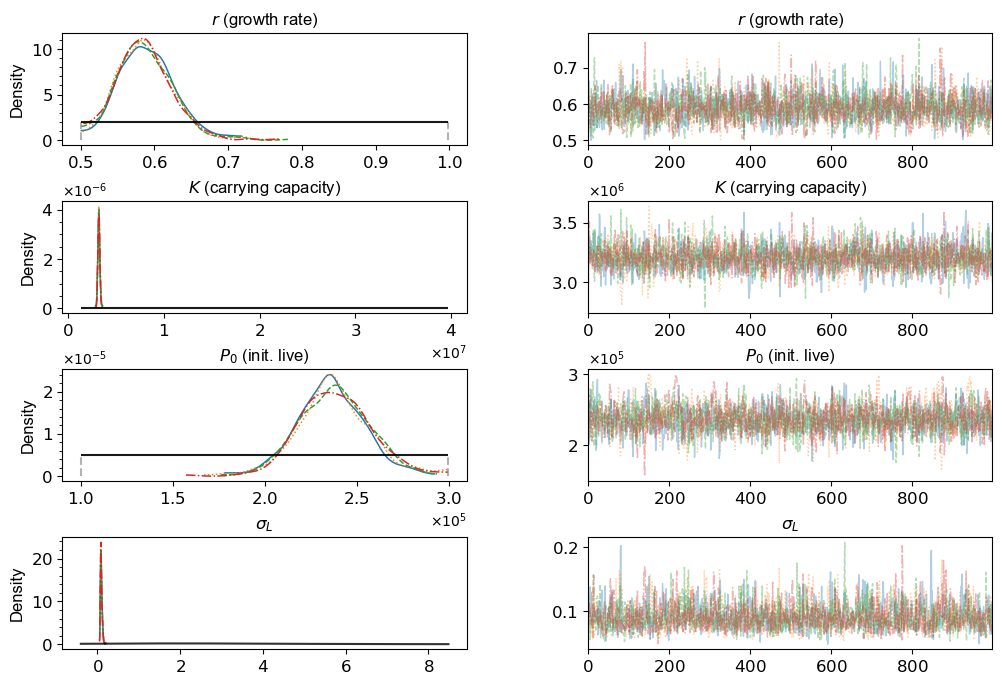

array([[<Axes: title={'center': '$r$ (growth rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$r$ (growth rate)'}>],
       [<Axes: title={'center': '$K$ (carrying capacity)'}, ylabel='Density'>,
        <Axes: title={'center': '$K$ (carrying capacity)'}>],
       [<Axes: title={'center': '$P_0$ (init. live)'}, ylabel='Density'>,
        <Axes: title={'center': '$P_0$ (init. live)'}>],
       [<Axes: title={'center': '$\\sigma_L$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_L$'}>]], dtype=object)

In [7]:
plot_trace(trace=trace,
           model=model,
           uni=["$r$ (growth rate)", "$K$ (carrying capacity)", "$P_0$ (init. live)"],
           fontname='Arial',
           fontsize=12,
           num_prior_samples=200,
           save_path='figures/vardi_logistic_growth_chains.png')

Now we interpret the results. Remember the ODE's from before.

$$
\frac{dP}{dt} = r \left(1 - \frac{P}{K}\right) P
$$

Take note of x-axis values at the peaks of the PDFs and the variables they represent. The x-axis values at those peaks are what the model found to be the optimal value for the equation. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space well enough. 


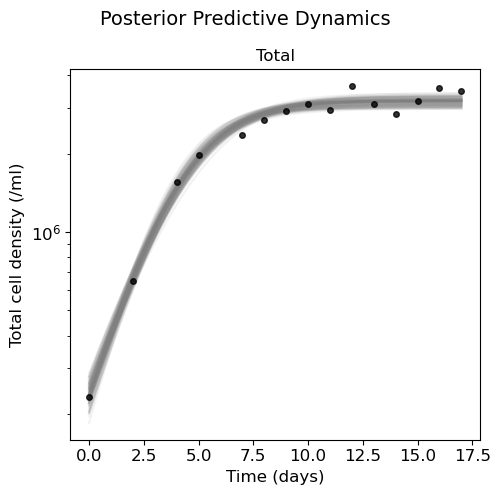

(<Figure size 500x500 with 1 Axes>,
 [<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>])

In [8]:
dataset_postprocessing = {
"Total cells": [
        {"time": cells_time, "values":  cells_density},  # replicate 1
    ]
}

def ode_solution2data(solution):
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

posterior_dynamics(dataset=dataset_postprocessing,
                   trace=trace,
                   model=model,
                   n_plots=100,
                   burn_in=50,
                   num_variables=1,
                   ode_fn=logistic_growth,
                   ode2data_fn=ode_solution2data,
                   save_path="figures/vardi_logistic_growth_dynamics.png",
                   var_properties={"Total cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}},
                   suptitle="Posterior Predictive Dynamics")

This plot is showing how well the range of estimated chains fit the observed data. 

**CONGRATULATIONS!** you just ran you first MCMC!

## Case Study 2: Logistic Growth and Death

Now on to a more complex model. We will be using the same data as before alongside new dead cell data. We will also being using two ODEs!

In [9]:
## Cell 6 ##

import pandas as pd

# import alive
dataset = pd.read_csv("../../../case_study_2/python/data/total_cells.csv")
cells = dataset.tail(15)
cells_time = cells['Time (days)'].values
cells_density = 1e6*cells[' Density (1e6/ml)'].values
log_cells_density = np.log(cells_density + 1e-9)

# import dead
death_dataset = pd.read_csv("../../../case_study_2/python/data/death_percentage.csv")
death = death_dataset.tail(15)
dead_time = death['Time (days)'].values
dead_density = death[' Dead percentage '].values*cells_density/100
log_dead_density = np.log(dead_density + 1e-9)


**ODE for living cells accounting for cell death**

$$
\frac{dP}{dt} = r \left(1 - \frac{P}{K}\right) P - \delta P
$$

**ODE for dead cells**

$$
\frac{dD}{dt} = \delta P
$$

We follow the same rules as before when creating this ODE. The new part of this is how we return the equation to PYMC (As an ODE system). Note that in our previous ODE we returned an equation of lists to to PyMC that looked like

[] = [] * (1 = [] / []) * []

Since PyMC expects a matrix as a return value, it was able to accept the 1-D column right there since that is still a matrix. 

We take advantage of this when we have multiple equations. All you have to do is expand the matrix.

x[[],[]]  
x[0] = [] * (1 = [] / []) * [] - [] * []  
x[1] = [] * []  
give x to PyMC

In [10]:
## Cell 7 ##

def logistic_growth_death(y, t, params):
    P = y[0]
    r = params[0]
    K = params[1]
    delta = params[2]

    dydt = []
    dydt.append(r * (1 - P / K) * P - delta * P)
    dydt.append(delta * P)
    return dydt

Here we have our new model setup. We have 3 unique parameters (r, K, delta) so we'll set **n_theta** to 3. **n_states** will now be 2 since we now have two ODE's we are tracking two states (alive, dead). 

**note**: We will end up with 5 priors for the 5 variables just mentioned. Plus two more for sigma_live and sigma_dead. Totaling 7.

In [11]:
## Cell 8 ##
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth_death,
    times=cells_time,
    n_states=2,
    n_theta=3, 
    t0=0
)

Here is the model. Everything here should make sense. If something is confusing see the explination above cell 4. Still note that we have two likelihoods at the bottom since we are estimating two states. 

In [12]:
## Cell 10 ##
import numpy as np
with pm.Model() as model:
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    delta = pm.Uniform(r"$\delta$ (death rate)", lower=0.0, upper=0.15)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    D0 = pm.Uniform(r"$D_0$ (init. dead)", lower=1e4, upper=7e4)

    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)
    sigma_dead = pm.HalfNormal(r"$\sigma_D$", 3)

    sol = cell_model(y0=[P0,D0], theta=[r,K,delta])
    total_solution = sol[:,0] + sol[:,1]
    dead_solution = sol[:,1]

    pm.Normal("Y_live", mu=pm.math.log(total_solution + 1e-9),sigma=sigma_live,
            observed=log_cells_density)
        
    pm.Normal("Y_dead", mu=pm.math.log(dead_solution + 1e-9),sigma=sigma_dead,
            observed=log_dead_density)

Everything here is that same as before! See the explination above cell 5 if you forgot something.

In [13]:
## Cell 11 ##

with model:
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                      target_accept=0.95) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$r$ (growth rate), $K$ (carrying capacity), $\delta$ (death rate), $P_0$ (init. live), $D_0$ (init. dead), $\sigma_L$, $\sigma_D$]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 633 seconds.


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Whisk\AppData\Local\Temp\ipykernel_39824\4226420622.py:3: SyntaxWarning: invalid escape sequence '\d'
  uni=["$r$ (growth rate)", "$K$ (carrying capacity)", "$\delta$ (death rate)", "$P_0$ (init. live)", "$D_0$ (init. dead)"],
Sampling: [$D_0$ (init. dead), $K$ (carrying capacity), $P_0$ (init. live), $\delta$ (death rate), $\sigma_D$, $\sigma_L$, $r$ (growth rate), Y_dead, Y_live]


$r$ (growth rate)
$K$ (carrying capacity)
$\delta$ (death rate)
$P_0$ (init. live)
$D_0$ (init. dead)
$\sigma_L$
$\sigma_D$


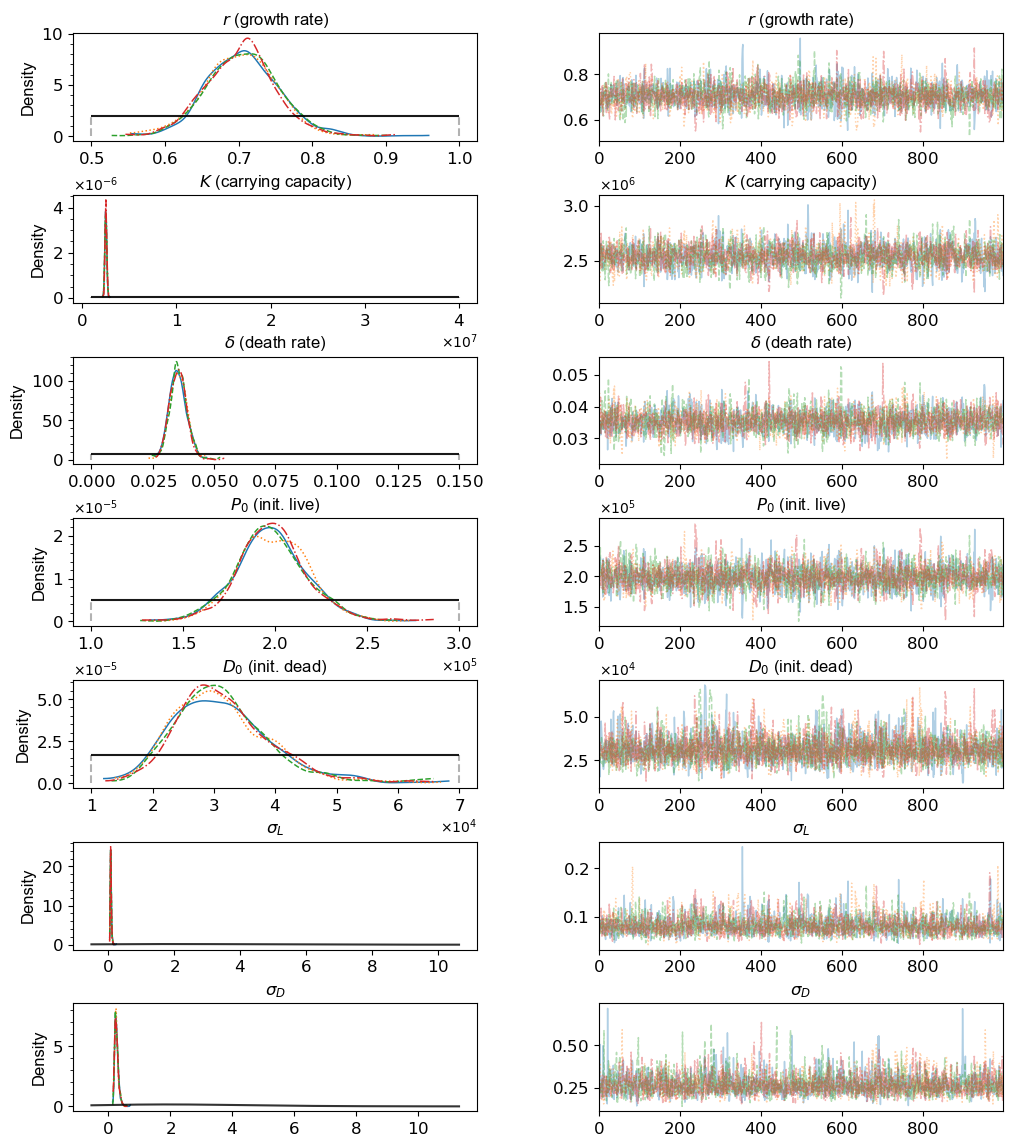

array([[<Axes: title={'center': '$r$ (growth rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$r$ (growth rate)'}>],
       [<Axes: title={'center': '$K$ (carrying capacity)'}, ylabel='Density'>,
        <Axes: title={'center': '$K$ (carrying capacity)'}>],
       [<Axes: title={'center': '$\\delta$ (death rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$\\delta$ (death rate)'}>],
       [<Axes: title={'center': '$P_0$ (init. live)'}, ylabel='Density'>,
        <Axes: title={'center': '$P_0$ (init. live)'}>],
       [<Axes: title={'center': '$D_0$ (init. dead)'}, ylabel='Density'>,
        <Axes: title={'center': '$D_0$ (init. dead)'}>],
       [<Axes: title={'center': '$\\sigma_L$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_L$'}>],
       [<Axes: title={'center': '$\\sigma_D$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_D$'}>]], dtype=object)

In [14]:
plot_trace(trace=trace,
           model=model,
           uni=["$r$ (growth rate)", "$K$ (carrying capacity)", "$\delta$ (death rate)", "$P_0$ (init. live)", "$D_0$ (init. dead)"],
           fontname='Arial',
           fontsize=12,
           num_prior_samples=2000,
           save_path='figures/vardi_growth_death_chains.png')

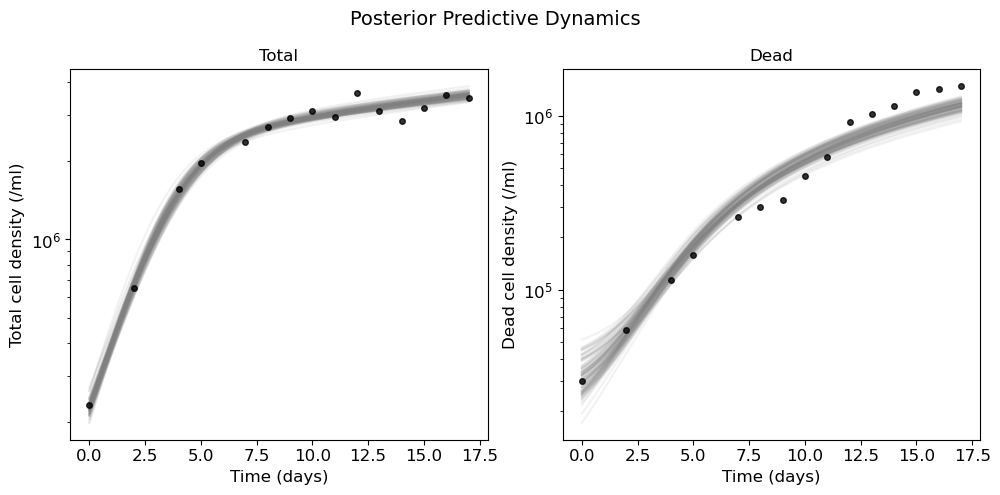

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>,
        <Axes: title={'center': 'Dead'}, xlabel='Time (days)', ylabel='Dead cell density (/ml)'>],
       dtype=object))

In [15]:
dataset_postprocessing = {
"Total cells": [
        {"time": cells_time, "values":  cells_density},  # replicate 1
    ],
"Dead cells": [
        {"time": dead_time, "values": dead_density},  # replicate 1
    ]
}

def ode_solution2data(solution):
    live = solution[:, 0]
    dead = solution[:, 1]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

posterior_dynamics(dataset=dataset_postprocessing,
                   trace=trace,
                   model=model,
                   n_plots=100,
                   burn_in=50,
                   num_variables=2,
                   ode_fn=logistic_growth_death,
                   ode2data_fn=ode_solution2data,
                   save_path="figures/vardi_growth_death_dynamics.png",
                   var_properties={
                       "Total cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)", "sol_key": "total","log": True},
                       "Dead cells": {"label": "Dead", "color": "black", "ylabel": "Dead cell density (/ml)", "xlabel":"Time (days)", "sol_key": "dead","log": True},
                   },
                   suptitle="Posterior Predictive Dynamics")